Data Processing Notebook
===

Prepare data for the analysis. The raw data is downloaded from the FAIR Universe HiggsML challenge repository. Use the HiggsML package to download and process the dataset, followed by selections and saving to local cache.



In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import yaml
from utils import plot_kinematic_features

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from HiggsML.systematics import systematics
hep.style.use(hep.style.ATLAS)

from HiggsML.datasets import download_dataset

ModuleNotFoundError: No module named 'numpy'

In [2]:
data = download_dataset("https://zenodo.org/records/15131565/files/FAIR_Universe_HiggsML_data.zip")

2025-08-08 07:45:25,620 - HiggsML.datasets     - INFO     - Handling as URL: https://zenodo.org/records/15131565/files/FAIR_Universe_HiggsML_data.zip
2025-08-08 07:45:25,622 - HiggsML.datasets     - INFO     - Current working directory: /data/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau
2025-08-08 07:45:25,773 - HiggsML.datasets     - INFO     - Total rows: 220099101
2025-08-08 07:45:25,774 - HiggsML.datasets     - INFO     - Test size: 66029730


In [3]:
with open("config_new.yml", "r") as f:
    config = yaml.safe_load(f)

In [4]:
config

{'path_prefix': '/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/',
 'path_saved_data': 'cached_data_new/',
 'path_preselection_NN_model': 'preselection_saved_NN/',
 'path_to_nominal_dataframe': 'f"df_nominal.h5"',
 'features': ['DER_mass_transverse_met_lep',
  'log_DER_mass_vis',
  'log_DER_pt_h',
  'DER_deltar_had_lep',
  'log_DER_pt_tot',
  'log_DER_sum_pt',
  'DER_pt_ratio_lep_had',
  'DER_met_phi_centrality'],
 'features_scaling': ['DER_mass_transverse_met_lep',
  'log_DER_mass_vis',
  'log_DER_pt_h',
  'DER_deltar_had_lep',
  'log_DER_pt_tot',
  'log_DER_sum_pt',
  'DER_pt_ratio_lep_had',
  'DER_met_phi_centrality'],
 'signal_processes': ['htautau'],
 'background_processes': ['ttbar', 'ztautau'],
 'ref_processes': ['htautau', 'ttbar'],
 'labels_dict': {'htautau': 0, 'ztautau': 1, 'ttbar': 2}}

In [5]:
# path prefix for saving cached data used between modules
path_prefix = config['path_prefix']
path_saved_data = config['path_saved_data']

# Path for saving interemdiate objects, like NN predictions
saved_data = f'{path_prefix}{path_saved_data}'

if not os.path.exists(saved_data):
    print(f"Making new directory for caching data {saved_data}")
    os.makedirs(saved_data)

# Get the dictionary that assigns an integer with each of the processes
labels_dict = config["labels_dict"]
print(labels_dict)

{'htautau': 0, 'ztautau': 1, 'ttbar': 2}


In [6]:
list_of_processes = list(labels_dict.keys())

In [7]:
data.load_train_set(train_size=0.35)
df_training_full = data.get_train_set()
del data

2025-08-08 07:45:40,205 - HiggsML.datasets     - INFO     - Selected train size: 53924279
2025-08-08 07:52:01,340 - HiggsML.datasets     - INFO     - Data loaded successfully


In [8]:
process_to_exclude = set(df_training_full.detailed_labels.unique()) - set(labels_dict.keys())
process_to_exclude = list(process_to_exclude)
print(process_to_exclude)

['diboson']


In [9]:
mask_process_exclusion = ~np.isin(df_training_full.detailed_labels, process_to_exclude)

df_training_full = df_training_full[mask_process_exclusion].copy()
df_training_full.detailed_labels.value_counts()

detailed_labels
ztautau    34422396
htautau    17854618
ttbar       1517228
Name: count, dtype: int64

In [10]:
n_ttbar = df_training_full.loc[
    df_training_full.detailed_labels=='ttbar'
].shape[0]

df_list = []
for _, df_process in df_training_full.groupby('detailed_labels'):
    weight_sum_orig = df_process.weights.sum()
    df_sampled = df_process.sample(n = n_ttbar, random_state=42)
    df_sampled['weights'] *= weight_sum_orig / df_sampled['weights'].sum()
    df_list.append(df_sampled)
    del df_sampled

df_training = pd.concat(df_list).reset_index(drop=True)
del df_training_full, df_list

In [11]:
df_training['type'] = df_training['detailed_labels'].copy()

In [12]:
mask_selected_processes = np.isin(df_training.detailed_labels.to_numpy(), list_of_processes)
df_training = df_training[mask_selected_processes].copy()

In [13]:
df_training.detailed_labels.unique()

array(['htautau', 'ttbar', 'ztautau'], dtype=object)

In [14]:
df_training['train_labels'] = -1 

for key in labels_dict:
    df_training.loc[df_training['detailed_labels'] == key, 'train_labels'] = labels_dict[key]


In [15]:
df_training.columns.unique()

Index(['PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_had_pt', 'PRI_had_eta',
       'PRI_had_phi', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta',
       'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_n_jets',
       'PRI_jet_all_pt', 'PRI_met', 'PRI_met_phi', 'weights',
       'detailed_labels', 'labels', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_had_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_had', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'type', 'train_labels'],
      dtype='object')

In [16]:
input_features_noJets = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_had_pt', 'PRI_had_eta',
       'PRI_had_phi', 'PRI_met', 'PRI_met_phi', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltar_had_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_had', 'DER_met_phi_centrality']

input_features_1Jets = ['PRI_jet_leading_pt', 'PRI_jet_leading_eta',
       'PRI_jet_leading_phi',
       'PRI_jet_all_pt']

input_features_2Jets = ['PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet',
       'DER_lep_eta_centrality']

input_features_by_jet = {1:input_features_1Jets, 2: input_features_2Jets}

input_features_nJets = ['PRI_n_jets', 'njet_0', 'njet_1', 'njet_2']

input_features = input_features_noJets + input_features_1Jets + input_features_2Jets + input_features_nJets

In [17]:
syst_settings = {
    'TES_up': {'tes': 1.02},
    'TES_dn': {'tes': 0.98},
    'JES_up': {'jes': 1.02},
    'JES_dn': {'jes': 0.98}
}

dataset_dict = {}

dataset_dict['nominal'] = systematics(
        data_set = df_training,
        dopostprocess=False
        )

median_feature = {}

for feature in input_features_1Jets:

    median_feature[feature] = np.median(dataset_dict['nominal'].loc[dataset_dict['nominal']['PRI_n_jets'] >=1, feature])

for feature in input_features_2Jets:
    
    median_feature[feature] = np.median(dataset_dict['nominal'].loc[dataset_dict['nominal']['PRI_n_jets'] >=2, feature])
    
for sample_name, syst_args in syst_settings.items():
    dataset_dict[sample_name] = systematics(
        data_set = df_training, 
        dopostprocess=False, 
        **syst_args
    )

# del df_training


Selections
-

Preselect the dataset to remove phase space regions with low statistics

In [18]:
for sample, dataset in dataset_dict.items():

    mask_sel = (
        (dataset['DER_mass_transverse_met_lep'] <= 250.0) &
        (dataset['DER_mass_vis'] <= 500.0) &
        (dataset['DER_sum_pt'] <=1000) &
        (dataset['DER_pt_tot'] <=250) &
        (dataset['DER_deltar_had_lep'] <=4.5) &
        (dataset['DER_pt_h'] <=400) &
        (dataset['DER_pt_ratio_lep_had'] <= 9.0)
    )
    dataset = dataset[mask_sel].copy()
    
    dataset['njet_0'] = (dataset['PRI_n_jets'] == 0).astype(int)
    dataset['njet_1'] = (dataset['PRI_n_jets'] == 1).astype(int)
    dataset['njet_2'] = (dataset['PRI_n_jets'] >= 2).astype(int)

    # for each jet slot, create a mask and zero‐pad missing
    for i, feat_list in input_features_by_jet.items():
        # mask_i = 1 if this event has at least i jets, else 0
        mask_i = (dataset['PRI_n_jets'] >= i).astype(float)
        dataset[f'jet{i}_mask'] = mask_i

        for feat in feat_list:
            # set to median of the distribution when not enough jets
            dataset[feat] = dataset[feat].where(dataset['PRI_n_jets'] >= i, median_feature[feat])

    for feat in input_features.copy():

        kin = dataset[feat].to_numpy()
        
        if (np.amin(kin) > 0.0) and (np.amax(kin)>100):
            log_feat = 'log_'+feat
            dataset[log_feat] = np.log(kin+10.0)
            if log_feat not in input_features:
                input_features.append(log_feat)

    dataset_dict[sample] = dataset


In [19]:
sample = 'TES_up'

In [20]:
input_features

['PRI_lep_pt',
 'PRI_lep_eta',
 'PRI_lep_phi',
 'PRI_had_pt',
 'PRI_had_eta',
 'PRI_had_phi',
 'PRI_met',
 'PRI_met_phi',
 'DER_mass_transverse_met_lep',
 'DER_mass_vis',
 'DER_pt_h',
 'DER_deltar_had_lep',
 'DER_pt_tot',
 'DER_sum_pt',
 'DER_pt_ratio_lep_had',
 'DER_met_phi_centrality',
 'PRI_jet_leading_pt',
 'PRI_jet_leading_eta',
 'PRI_jet_leading_phi',
 'PRI_jet_all_pt',
 'PRI_jet_subleading_pt',
 'PRI_jet_subleading_eta',
 'PRI_jet_subleading_phi',
 'DER_deltaeta_jet_jet',
 'DER_mass_jet_jet',
 'DER_prodeta_jet_jet',
 'DER_lep_eta_centrality',
 'PRI_n_jets',
 'njet_0',
 'njet_1',
 'njet_2',
 'log_PRI_lep_pt',
 'log_PRI_had_pt',
 'log_PRI_met',
 'log_DER_mass_vis',
 'log_DER_pt_h',
 'log_DER_pt_tot',
 'log_DER_sum_pt',
 'log_PRI_jet_leading_pt',
 'log_PRI_jet_all_pt',
 'log_PRI_jet_subleading_pt',
 'log_DER_mass_jet_jet']

In [21]:
# Select the subset of features to keep in the saved dataset - remove unnecessary data
columns_to_keep = input_features + ['weights', 'detailed_labels', 'type', 'train_labels',
                                   'jet1_mask', 'jet2_mask']

for sample in dataset_dict:
    dataset_dict[sample] = dataset_dict[sample][columns_to_keep].copy()
    
# for sample in dataset_dict:
#     dataset_dict[sample] = dataset_dict[sample].loc[:, ~dataset_dict[sample].columns.duplicated()]

In [22]:
# Save the datasets for training and inference
for sample in dataset_dict: 
    path_to_data_save = f"{saved_data}df_{sample}.h5"
    dataset_dict[sample].to_hdf(path_to_data_save, key="dataset", mode="w")
    config[f"path_to_{sample}_dataframe"] = path_to_data_save

In [34]:
# Save the updated YAML back to the file
with open('config_new_test.yml', 'w') as file:
    yaml.dump(config, 
              file, 
              default_flow_style=False,
              sort_keys=False,           # Preserve order (requires PyYAML 5.1+)
        indent=12,                  # Better indentation
        width=1000                 # Prevent line wrapping
             )

Visualize the data
-

Check for low-stats phase space and effect from systematics before moving to the density ratio training.

In [24]:
import sys, importlib
importlib.reload(sys.modules['utils'])
from utils import plot_kinematic_features

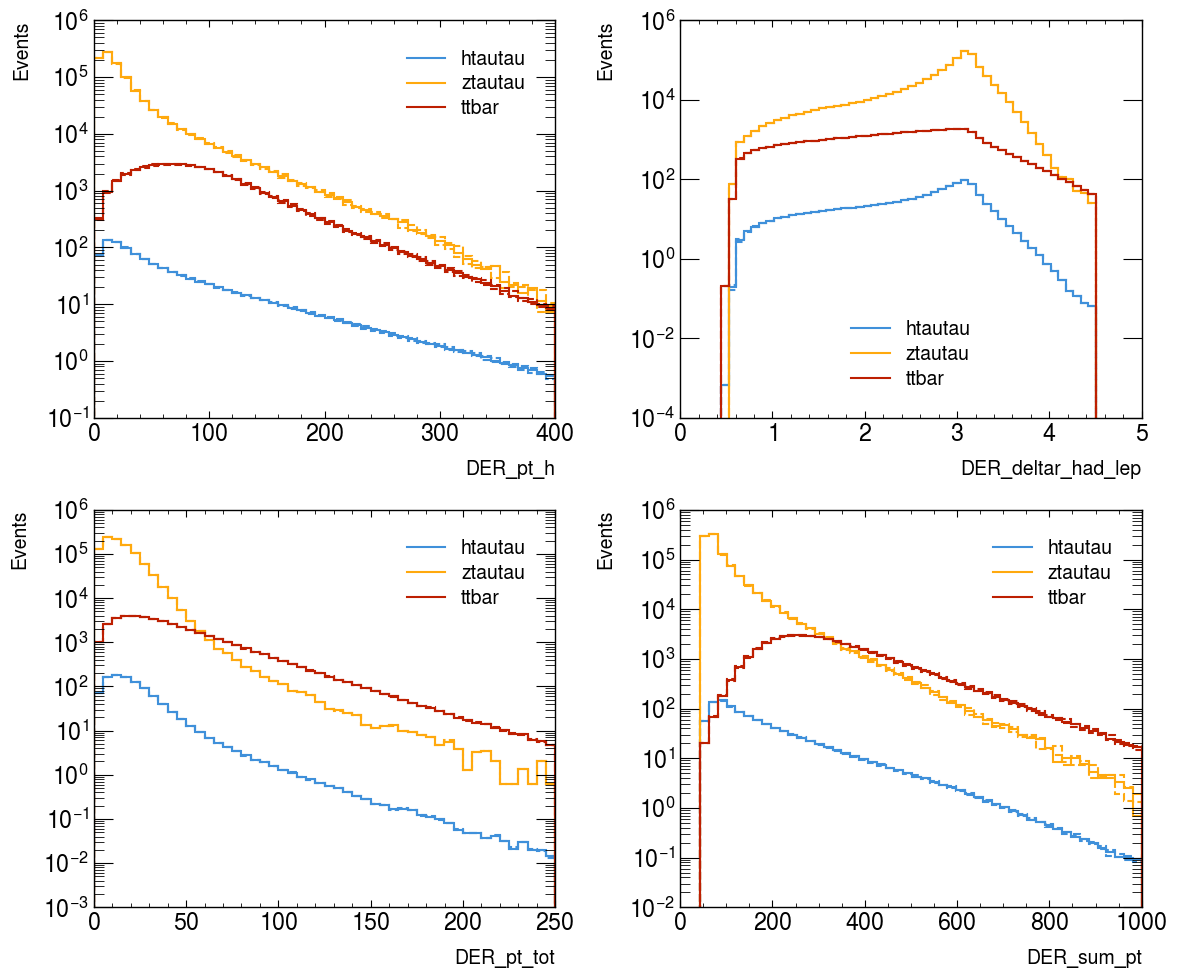

In [25]:
columns = ['DER_pt_h', 'DER_deltar_had_lep', 'DER_pt_tot', 'DER_sum_pt']
nbins = 50

xlabel_dict = {
    'PRI_lep_pt': 'lepton $p_T$ [GeV]', 
    'PRI_lep_eta': 'lepton $\\eta$ [GeV]', 
    'PRI_met': 'MET [GeV]', 
    'PRI_met_phi': 'MET $\\phi$',     
    'PRI_n_jets': '$n_{jets}$'      
}

variations_to_plot = ['nominal', 'JES_up', 'JES_dn']


fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=dataset_dict,
    xlabel_dict=xlabel_dict,
    labels_dict=labels_dict
)
plt.show()


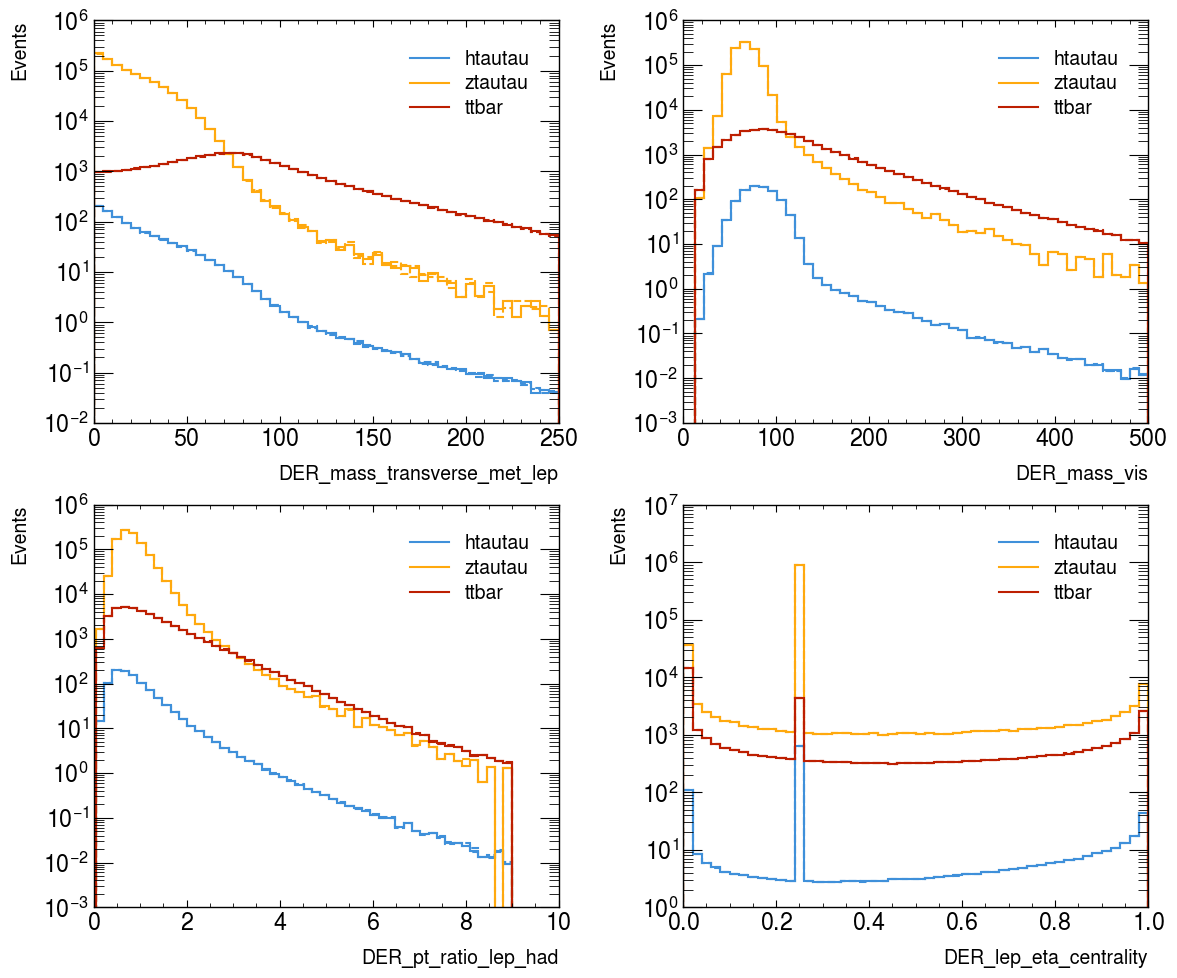

In [26]:
columns = ['DER_mass_transverse_met_lep', 'DER_mass_vis',
       'DER_pt_ratio_lep_had', 'DER_lep_eta_centrality']

nbins = 50

xlabel_dict = {
    'DER_mass_transverse_met_lep': 'DER_mass_transverse_met_lep', 
    'DER_mass_vis': 'DER_mass_vis', 
    'DER_pt_ratio_lep_had': 'DER_pt_ratio_lep_had', 
    'DER_lep_eta_centrality': 'DER_lep_eta_centrality',       
}

variations_to_plot = ['nominal', 'JES_up', 'JES_dn']


fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=dataset_dict,
    xlabel_dict=xlabel_dict,
    labels_dict=labels_dict
)
plt.show()


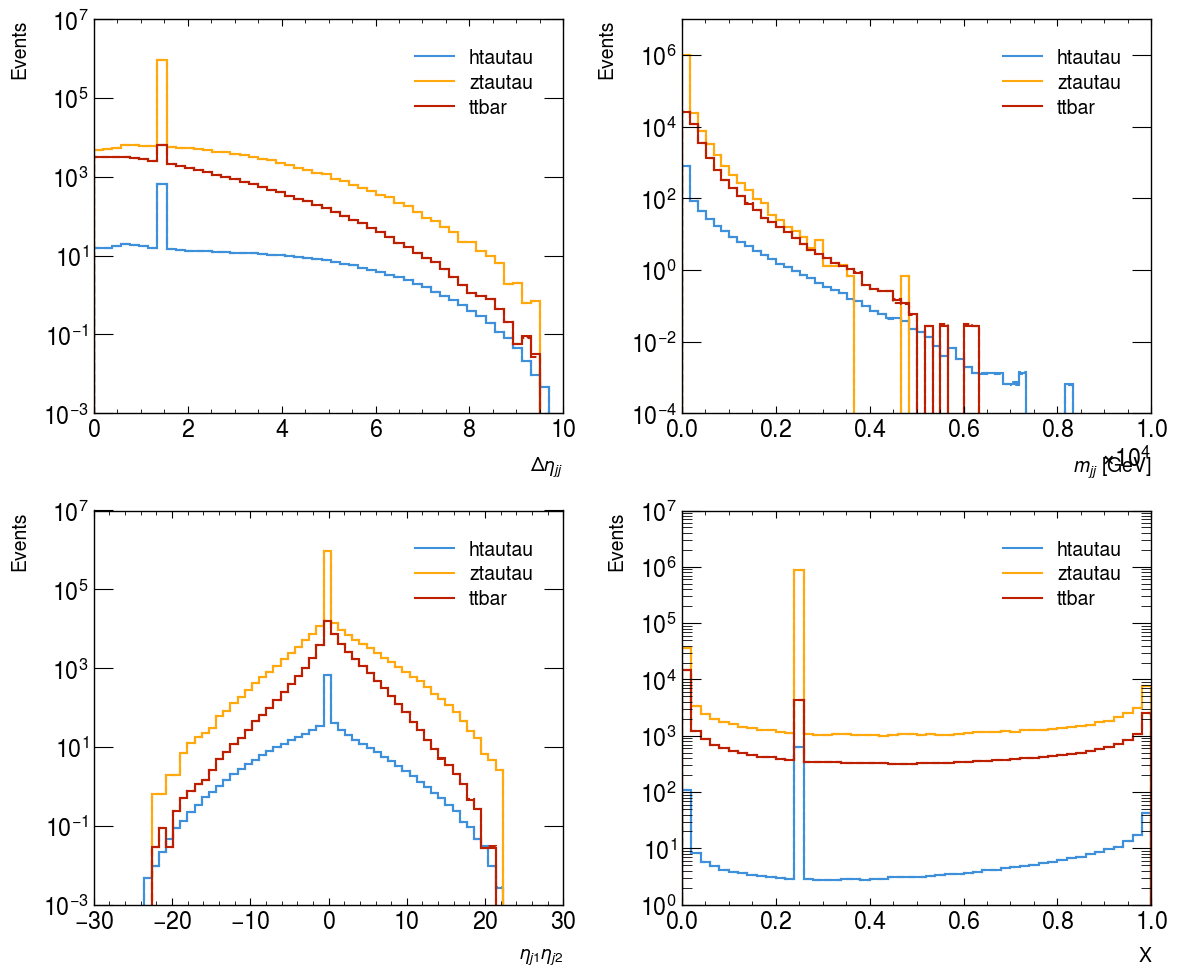

In [27]:
columns = ['DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 
           'DER_prodeta_jet_jet', 'DER_lep_eta_centrality']
nbins = 50

xlabel_dict = {
    'DER_deltaeta_jet_jet': r'$\Delta \eta_{jj}$', 
    'DER_mass_jet_jet': '$m_{jj}$ [GeV]', 
    'DER_prodeta_jet_jet': '$\eta_{j1}\eta_{j2}$', 
    'DER_lep_eta_centrality': 'X',
}

variations_to_plot = ['nominal', 'TES_up', 'TES_dn']

fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=dataset_dict,
    xlabel_dict=xlabel_dict,
    labels_dict=labels_dict
)
plt.show()

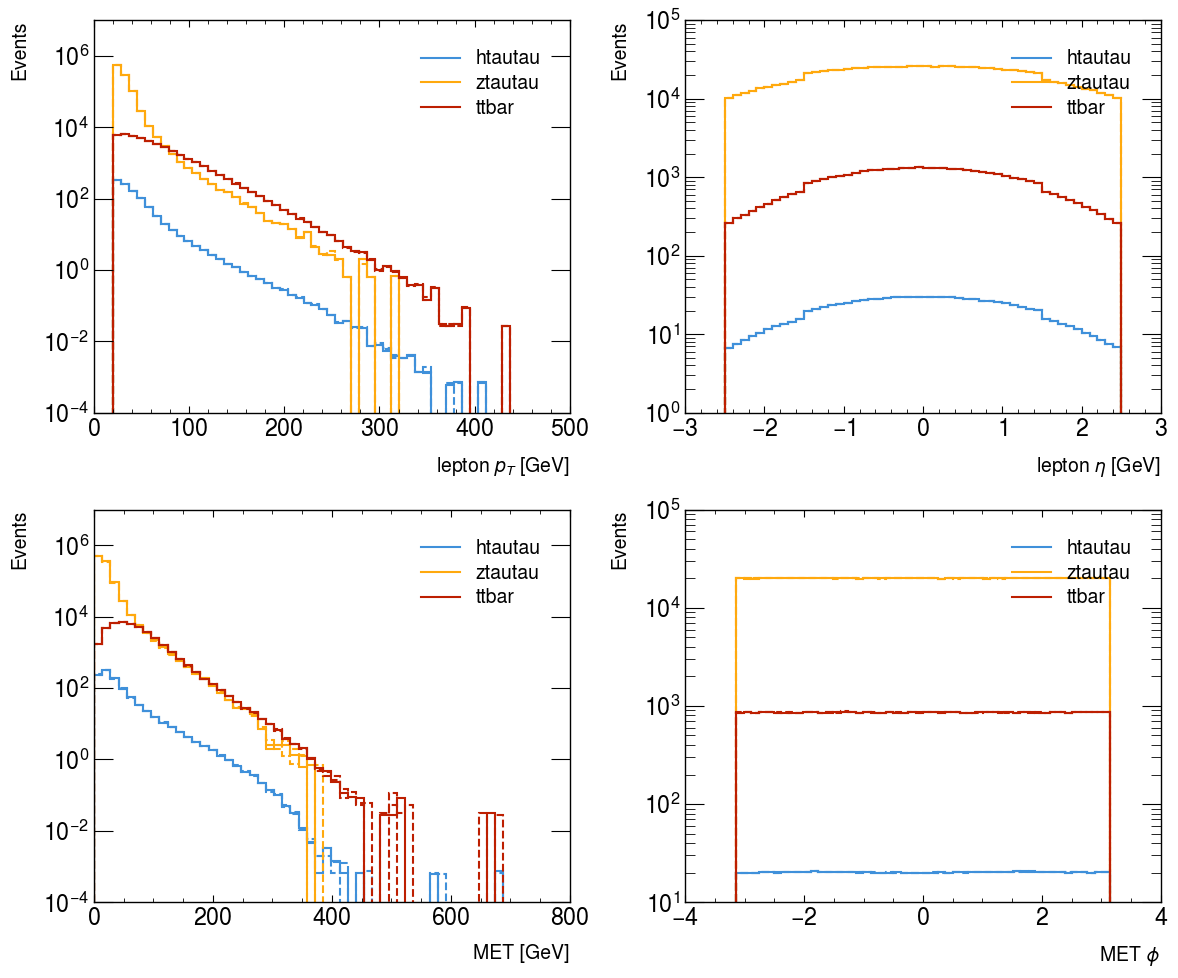

In [28]:
columns = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_met', 'PRI_met_phi']
nbins = 50

xlabel_dict = {
    'PRI_lep_pt': 'lepton $p_T$ [GeV]', 
    'PRI_lep_eta': 'lepton $\\eta$ [GeV]', 
    'PRI_met': 'MET [GeV]', 
    'PRI_met_phi': 'MET $\\phi$',     
    'PRI_n_jets': '$n_{jets}$'      
}

variations_to_plot = ['nominal', 'TES_up', 'TES_dn']


fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=dataset_dict,
    xlabel_dict=xlabel_dict,
    labels_dict=labels_dict
)
plt.show()


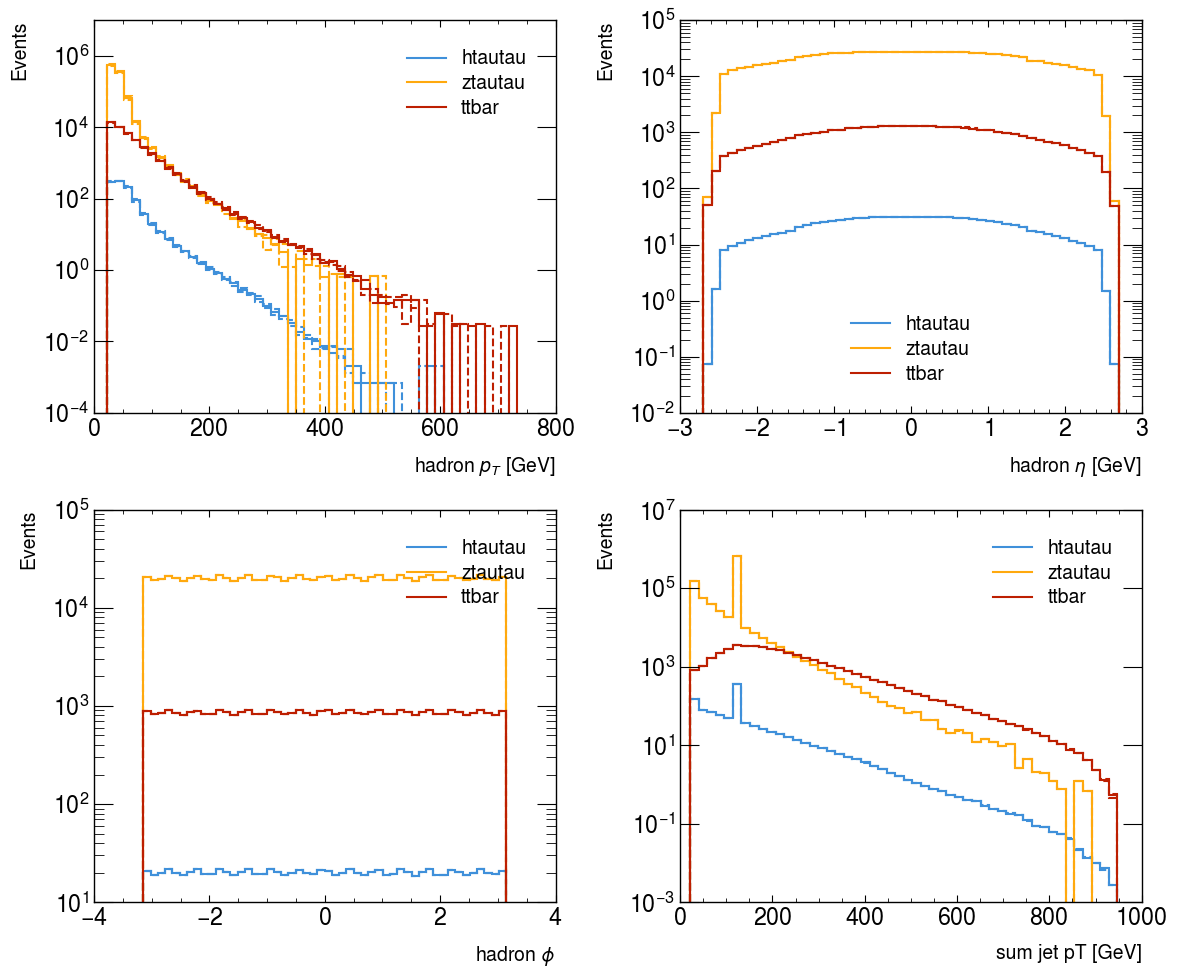

In [29]:
columns = ['PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi', 'PRI_jet_all_pt']
# columns = ['PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi']
nbins = 50

xlabel_dict = {
    'PRI_had_pt': 'hadron $p_T$ [GeV]', 
    'PRI_had_eta': 'hadron $\eta$ [GeV]', 
    'PRI_had_phi': 'hadron $\phi$', 
    'PRI_jet_all_pt': 'sum jet pT [GeV]',
}

variations_to_plot = ['nominal', 'TES_up', 'TES_dn']

fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=dataset_dict,
    xlabel_dict=xlabel_dict,
    labels_dict=labels_dict
)
plt.show()

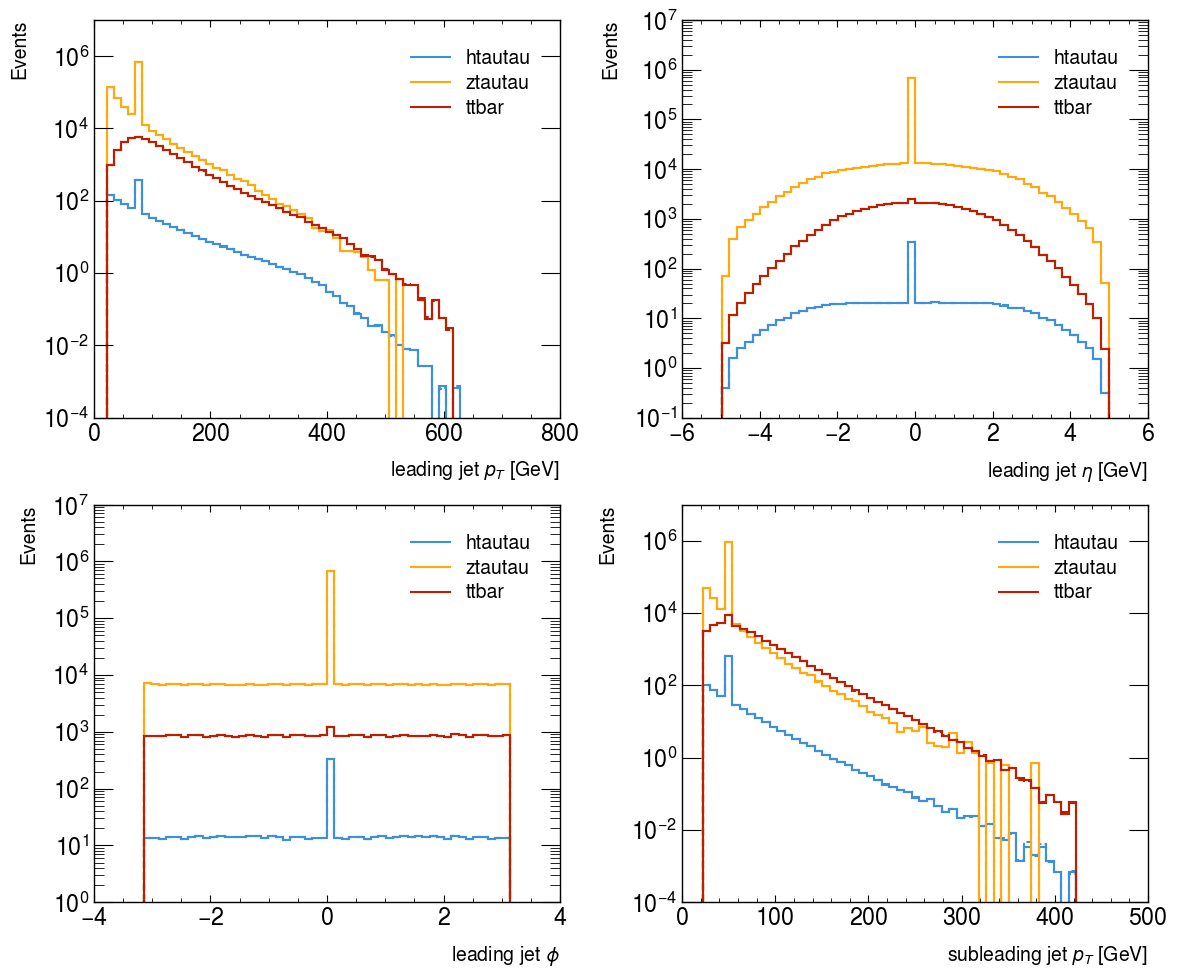

In [30]:
columns = ['PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt']

# columns = ['PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi']
nbins = 50

xlabel_dict = {
    'PRI_jet_leading_pt': 'leading jet $p_T$ [GeV]', 
    'PRI_jet_leading_eta': 'leading jet $\eta$ [GeV]', 
    'PRI_jet_leading_phi': 'leading jet $\phi$', 
    'PRI_jet_subleading_pt': 'subleading jet $p_T$ [GeV]',
}

variations_to_plot = ['nominal', 'TES_up', 'TES_dn']

fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=dataset_dict,
    xlabel_dict=xlabel_dict,
    labels_dict=labels_dict
)
plt.show()